In [1]:
# !pip install --quiet --pre dgl-cu101
# !pip install --quiet catboost
# !pip install --quiet category-encoders==2.2.2
# !pip install --quiet /mnt/dgl_cu102-0.6.0-cp36-cp36m-manylinux1_x86_64.whl
# !pip install --quiet torch==1.6.0

In [1]:
import argparse
import itertools
import time
import math
import pickle
import random
from tqdm import tqdm
tqdm.pandas(position=0, leave=True)

from collections import defaultdict as ddict
import pandas as pd
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
import json
import os

from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize

import catboost
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, sum_models
# import category_encoders
# from category_encoders import CatBoostEncoder

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
# import tsne_func

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import dgl
import dgl.nn as dglnn
import dgl.function as Fn

data_dir="/workspace/cjiang/eagle_project/CAP_graph/dataset/"
root_dir="/workspace/cjiang/eagle_project/CAP_graph/BGNN/"

os.chdir(root_dir)

print(catboost.__version__)
# print(category_encoders.__version__)
print(torch.__version__)

Using backend: pytorch


0.20.1
1.6.0


In [2]:
def seed_everything(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [3]:
KG_dir="/workspace/cjiang/eagle_project/CAP_graph/BGNN/"

start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph_v1'), 'rb') as f:
    G,multi_label,binary_label,\
    train_mask_multi_label,  val_mask_multi_label,  test_mask_multi_label,\
    train_mask_binary_label, val_mask_binary_label, test_mask_binary_label= pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))

It took 13.8632 seconds to load graph


In [4]:
usaanr_feat=[]
for key, scheme in G.node_attr_schemes(ntype="usaanr").items():
    usaanr_feat.append(key)
usaanr_feat=[x for x in usaanr_feat if x not in ['usaanr','cmpyelig','ACTCORP','Segment']]
usaanr_feat

['usaayr',
 'AGE_BAND',
 'ORIGEL',
 'ELIG2',
 'SEX',
 'MARST',
 'BRANCH',
 'ENLPAYGD',
 'MILST',
 'MLIST_OrigStat',
 'STATE']

In [5]:
class graph_2_df:
    def __init__(self,g):
        
        self.g=g
        
    def df_creation(self):
        usaanr_feat=[]
        for key, scheme in self.g.node_attr_schemes(ntype="usaanr").items():
            usaanr_feat.append(key)
        usaanr_feat=[x for x in usaanr_feat if x not in ['usaanr','cmpyelig','ACTCORP','Segment']]
        
        DF=pd.DataFrame()
        for i,col in enumerate(usaanr_feat):
            ndata=self.g.nodes['usaanr'].data[col].squeeze().numpy()
            DF[col]=ndata
        
        class_le=LabelEncoder()

        for i in tqdm(range(len(DF.columns)),position=0,leave=True):
            col=DF.columns[i]

            DF[col]=class_le.fit_transform(DF[col])
            DF[col]=DF[col].astype('str')
                
        return DF

DF=graph_2_df(G).df_creation()


100%|██████████| 11/11 [08:12<00:00, 44.73s/it]


In [6]:
categorical_index=np.where(DF.dtypes==object)[0]
categorical_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [10]:
def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=round(DF2.actual_label.sum()/(DF.actual_label.sum()),2)
    return gain

def get_class_count_weight(y,n_classes):
    classes_count=[]
    weight=[]
    for i in range(n_classes):
        count=np.sum(y.squeeze()==i)
        classes_count.append(count)
        weight.append(len(y)/(n_classes*count))
    return classes_count,weight

def evaluate(target, predicted):
    true_label_mask=[1 if (np.argmax(x)-target[i])==0 else 0 for i,x in enumerate(predicted)]
    nb_prediction=len(true_label_mask)
    true_prediction=sum(true_label_mask)
    false_prediction=nb_prediction-true_prediction
    accuracy=true_prediction/nb_prediction
    
    precision, recall, fscore, support = precision_recall_fscore_support(target, predicted.argmax(axis=1))
    auc = roc_auc_score(target.ravel(), torch.sigmoid(torch.from_numpy(predicted))[:,1].numpy().ravel())
    
    prec,rec,_ = precision_recall_curve(target.ravel(), torch.sigmoid(torch.from_numpy(predicted))[:,1].numpy().ravel())
    
    pr_auc=auc_score(rec,prec)
    
    arg1=predicted[:,1]
    arg2=target
    gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
    
    return {
        "nb_example":len(target),
        "true_prediction":true_prediction,
        "false_prediction":false_prediction,
        "accuracy":accuracy,
        "precision":precision[1], 
        "recall":recall[1], 
        "f1_score":fscore[1],
        "AUC":auc,
        "pr_auc":pr_auc,
        "GAIN":gain
    }

#### LABEL

In [11]:
y=binary_label.squeeze().numpy()
n_classes=torch.unique(binary_label).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
# imbalance_classes["category"]=torch.unique(binary_label).tolist()
imbalance_classes["Auto or Not"]=["No","Yes"]
imbalance_classes["count"]=classes_count
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","weight":"{:.2f}"})

,Auto or Not,count,weight
0,No,"19,358,913",0.66
1,Yes,"6,309,591",2.03


Text(0.5, 1.0, 'Distribution of Target Variables')

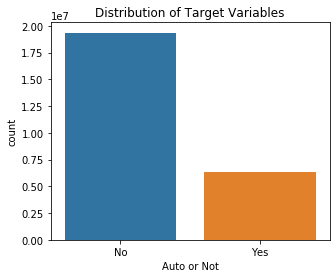

In [12]:
import seaborn as sns
sns.barplot(x="Auto or Not",y="count",data=imbalance_classes)
plt.title("Distribution of Target Variables")

#### setting up Training, Validation and Test set

In [14]:
train_idx=torch.nonzero(train_mask_binary_label.squeeze()).numpy()
val_idx=torch.nonzero(val_mask_binary_label.squeeze()).numpy()
test_idx=torch.nonzero(test_mask_binary_label.squeeze()).numpy()

train_idx=torch.from_numpy(train_idx).squeeze()    
val_idx=torch.from_numpy(val_idx).squeeze()    
test_idx=torch.from_numpy(test_idx).squeeze()

label_train=binary_label[train_idx].squeeze().numpy()
label_val=binary_label[val_idx].squeeze().numpy()
label_test=binary_label[test_idx].squeeze().numpy()

df_train=DF.loc[train_idx,:]
df_val=DF.loc[val_idx,:]
df_test=DF.loc[test_idx,:]

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    20,534,804
validation set  2,566,850 
test set        2,566,850 


In [15]:
num_classes=torch.unique(torch.from_numpy(label_train)).shape[0]
train_classes_num, train_classes_weight = get_class_count_weight(label_train,num_classes)

In [16]:
%%time
params = {'loss_function':'MultiClass',
         'learning_rate' : 0.01,
         'iterations' : 3000,
         'cat_features' : categorical_index,
         'early_stopping_rounds'  : 200,
         'random_seed' : 101,
         'task_type' : "GPU",
         'class_weights':train_classes_weight,
         'verbose' : 200}

model=CatBoostClassifier(**params)
model.fit(df_train, label_train, eval_set=(df_val,label_val),use_best_model=True,early_stopping_rounds=50)

0:	learn: 0.6897200	test: 0.6897005	best: 0.6897005 (0)	total: 110ms	remaining: 5m 30s
200:	learn: 0.4837792	test: 0.4836700	best: 0.4836700 (200)	total: 22.1s	remaining: 5m 8s
400:	learn: 0.4633487	test: 0.4632950	best: 0.4632950 (400)	total: 43.3s	remaining: 4m 40s
600:	learn: 0.4575611	test: 0.4575506	best: 0.4575506 (600)	total: 1m 3s	remaining: 4m 14s
800:	learn: 0.4545142	test: 0.4545356	best: 0.4545356 (800)	total: 1m 23s	remaining: 3m 49s
1000:	learn: 0.4525684	test: 0.4526254	best: 0.4526254 (1000)	total: 1m 44s	remaining: 3m 27s
1200:	learn: 0.4512484	test: 0.4513199	best: 0.4513199 (1200)	total: 2m 4s	remaining: 3m 6s
1400:	learn: 0.4502773	test: 0.4503662	best: 0.4503662 (1400)	total: 2m 24s	remaining: 2m 45s
1600:	learn: 0.4495123	test: 0.4496009	best: 0.4496009 (1600)	total: 2m 44s	remaining: 2m 23s
1800:	learn: 0.4488716	test: 0.4489627	best: 0.4489627 (1800)	total: 3m 4s	remaining: 2m 3s
2000:	learn: 0.4483685	test: 0.4484607	best: 0.4484607 (2000)	total: 3m 25s	remaini

#### Performance Evaluation

In [17]:
LOGIT_train = model.predict_proba(df_train)
LABEL_train = label_train
train_PV=evaluate(LABEL_train, LOGIT_train)
train_PV

{'nb_example': 20534804,
 'true_prediction': 15255334,
 'false_prediction': 5279470,
 'accuracy': 0.7429013688175451,
 'precision': 0.48644566142695234,
 'recall': 0.8240292110839985,
 'f1_score': 0.6117560023914702,
 'AUC': 0.8578242907910664,
 'pr_auc': 0.6496103009747048,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.3}}

In [18]:
LOGIT_val = model.predict_proba(df_val)
LABEL_val = label_val
val_PV=evaluate(LABEL_val, LOGIT_val)
val_PV

{'nb_example': 2566850,
 'true_prediction': 1906426,
 'false_prediction': 660424,
 'accuracy': 0.7427103258858133,
 'precision': 0.4862123794255852,
 'recall': 0.8234021544981528,
 'f1_score': 0.6113987137317666,
 'AUC': 0.8576032557618176,
 'pr_auc': 0.6498680921570028,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.3}}

In [19]:
LOGIT_test = model.predict_proba(df_test)
LABEL_test = label_test
test_PV=evaluate(LABEL_test, LOGIT_test)
test_PV

{'nb_example': 2566850,
 'true_prediction': 1907008,
 'false_prediction': 659842,
 'accuracy': 0.742937062937063,
 'precision': 0.48648420997462777,
 'recall': 0.8238316594263653,
 'f1_score': 0.61173203095119,
 'AUC': 0.8580194199823665,
 'pr_auc': 0.6502865149765485,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.3}}

#### Model Save

In [20]:
if not os.path.exists("model_save"):
    os.makedirs("model_save")
model.save_model("model_save/CatBoost")

#### Score Test Dataset

In [21]:
%%time
LOGIT_test = model.predict_proba(df_test)
LABEL_test = label_test

savez_compressed("model_save/Catboost_LOGIT.npz", LOGIT_test)
savez_compressed("model_save/Catboost_LABEL.npz", LABEL_test)

# os.system("rm /mnt/bgnn/model_save/Catboost_LOGIT.npz")
# os.system("rm /mnt/bgnn/model_save/Catboost_LABEL.npz")

CPU times: user 48.1 s, sys: 2.4 s, total: 50.5 s
Wall time: 18 s


In [22]:

fin_logits_graph = load("model_save/Catboost_LOGIT.npz")['arr_0']
fin_targets_graph = load("model_save/Catboost_LABEL.npz")['arr_0']

tmp_graph=evaluate(fin_targets_graph, fin_logits_graph)
print("")
print("==> Running Validation on validation set \n")
print("")

print("True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
ROC_AUC: {:.1%} | PR_AUC: {:.1%}".format(tmp_graph["true_prediction"], tmp_graph["false_prediction"], tmp_graph["accuracy"], \
                                                        tmp_graph["precision"], tmp_graph["recall"], tmp_graph["f1_score"], tmp_graph["GAIN"]['10%'], \
                                                        tmp_graph["AUC"], tmp_graph["pr_auc"]))


==> Running Validation on validation set 


True_Prediction: 1,907,008 | False_Prediction: 659,842 | accuracy: 74.29% |  precision: 48.65% | recall: 82.38% | F1_score: 61.17% | Gain_top-10%: 0.3 |ROC_AUC: 85.8% | PR_AUC: 65.0%


In [23]:
tmp_graph

{'nb_example': 2566850,
 'true_prediction': 1907008,
 'false_prediction': 659842,
 'accuracy': 0.742937062937063,
 'precision': 0.48648420997462777,
 'recall': 0.8238316594263653,
 'f1_score': 0.61173203095119,
 'AUC': 0.8580194199823665,
 'pr_auc': 0.6502865149765485,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.3}}